## 1. 读取数据

In [1]:
import pandas as pd
import os

file_path = os.path.join("data/comment.csv")

#读取test.csv文件中的A、B列，若不设置usecols参数，默认读取全部数据。
df = pd.read_csv(open(file_path,'r',encoding='utf-8'), names=["用户名","星评","评论时间","评论"])
df.head()

,用户名,星评,评论时间,评论
0,苏樱,力荐,2021-09-29 14:35:14,沂蒙山小调一出，仿佛回到了很多年我的家乡，山东省临沂市沂水县下虎峪村，我在听外公讲他抗战时候...
1,摩诃曼珠沙华,推荐,2021-09-30 19:02:14,那些牺牲在冰雪中的战士，不应该被遗忘
2,觉日尧,推荐,2021-09-29 22:11:46,小村庄夜战那段简直了，一看就是林超贤导演的手笔。炮兵、狙击手、机关枪手，扔手雷、近身肉搏，安...
3,江上悬鱼,推荐,2021-09-30 19:09:31,场面拍得挺好，但总觉得少了点什么。
4,吴点半,还行,2021-09-27 18:16:24,只说实话：1、片长太长，对观众非常不友好。战争戏完全可以减少，士兵互相闹着玩的戏完全可以删减...


## 2. 分析数据
### 2.1 分析评分

In [2]:
star_num = df.星评.value_counts()
star_num = star_num.sort_index()
star_num

力荐        151
很差          4
推荐         60
该用户未星评      4
较差         28
还行         73
Name: 星评, dtype: int64

In [3]:
from pyecharts.charts import Pie, Bar, Line, Page
from pyecharts import options as opts
from pyecharts.globals import SymbolType

# 数据对
data_pair = [list(z) for z in zip([i for i in star_num.index], star_num.values.tolist())]

# 饼图
pie1 = Pie(init_opts=opts.InitOpts(width='800px', height='400px'))
pie1.add('',data_pair,radius=['35%','60%'])
pie1.set_global_opts(title_opts=opts.TitleOpts(title='豆瓣短评评分占比'),
                     legend_opts=opts.LegendOpts(orient='vertical', pos_top='15%', pos_left='2%')
                    )

pie1.set_series_opts(label_opts=opts.LabelOpts(formatter='{b}:{d}%'))
pie1.render_notebook()

### 2.2 分析评论数量走势

In [4]:
# 先获取每天的评论数量
comment_date = {}
for item in df.评论时间:
    if comment_date.get(item.split(' ')[0], 0) == 0:
        comment_date[item.split(' ')[0]] = 0
    comment_date[item.split(' ')[0]] += 1    
print(comment_date)
comment_date = pd.DataFrame.from_dict(comment_date, orient='index')
comment_date.sort_index(axis=0, ascending=True, inplace=True)
print(comment_date)

{'2021-09-29': 45, '2021-09-30': 87, '2021-09-27': 7, '2021-10-05': 19, '2021-09-28': 7, '2021-10-01': 45, '2021-09-25': 7, '2021-10-03': 15, '2021-10-04': 17, '2021-09-26': 14, '2021-10-02': 25, '2021-10-13': 2, '2021-10-06': 4, '2021-10-08': 7, '2021-10-07': 5, '2021-10-10': 5, '2021-10-09': 5, '2021-10-25': 1, '2021-10-24': 1, '2021-10-11': 1, '2021-10-18': 1}
             0
2021-09-25   7
2021-09-26  14
2021-09-27   7
2021-09-28   7
2021-09-29  45
2021-09-30  87
2021-10-01  45
2021-10-02  25
2021-10-03  15
2021-10-04  17
2021-10-05  19
2021-10-06   4
2021-10-07   5
2021-10-08   7
2021-10-09   5
2021-10-10   5
2021-10-11   1
2021-10-13   2
2021-10-18   1
2021-10-24   1
2021-10-25   1


In [5]:
#折线图
line1 = Line(init_opts=opts.InitOpts(width='800px', height='400px'))
line1.add_xaxis(comment_date.index.tolist()).add_yaxis('',comment_date.values.tolist(), areastyle_opts=opts.AreaStyleOpts(opacity=0.5), label_opts=opts.LabelOpts(is_show=False))  # 
line1.set_global_opts(title_opts=opts.TitleOpts(title='评论数量走势图'),
#toolbox_opts=opts.ToolboxOpts(),
visualmap_opts=opts.VisualMapOpts(max_=140))
line1.set_series_opts(linestyle_opts=opts.LineStyleOpts(width=4))
line1.render_notebook()

### 2.3 词云分析
根据我们探索到的数据, 其实可以得到这样一个结论, 如果某个用户对该电影的评价比较"正面", 那么他的打分不会低于4颗星; 但是如果某个用户对该电影的评价不好, 那么他的打分不会超过3颗星. 存在打错分的情况, 但是这种情况很少, 几乎可以忽略不计.

#### 2.3.1 正面词云分析

In [6]:
!pip3 install jieba

In [7]:
import jieba

def get_cut_words(content_series):
    # 停用词表
    stop_words=[]

    #添加关键词
    my_words=['长津湖', '志愿军']
    for i in my_words:
        jieba.add_word(i)

    #自定义停用词
    my_stop_words = ['电影','长津湖','战争']
    stop_words.extend(my_stop_words)

    # 分词
    word_num = jieba.lcut(content_series.str.cat(sep='。'), cut_all=False)

    # 条件筛选
    word_num_selected = [i for i in word_num if i not in stop_words and len(i)>=2]

    return word_num_selected

In [9]:
text1 = get_cut_words(content_series=df[(df.星评=='力荐')|(df.星评=='推荐')]['评论'])
text1[:5]

['沂蒙山', '小调', '一出', '仿佛', '回到']

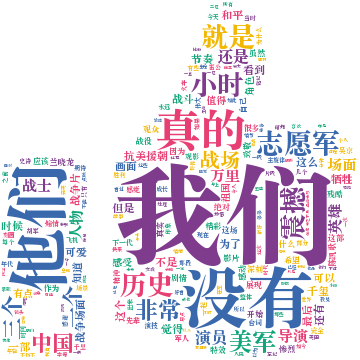

In [12]:
!pip3 install stylecloud
import stylecloud
from IPython.display import Image # 用于在jupyter lab中显示本地图片



# 绘制词云图
stylecloud.gen_stylecloud(text=' '.join(text1),
                            max_words=1000,
                            collocations=False,
                            font_path='/Library/Fonts/Songti.ttc',
                            icon_name='fas fa-thumbs-up',
                            size=360,
                            output_name='豆瓣正向评分词云图.png')

Image(filename='豆瓣正向评分词云图.png')

#### 2.3.2 负面词云分析
套路差不多

In [13]:
text2 = get_cut_words(content_series=df[(df.星评=='还行')|(df.星评=='较差')|(df.星评=='很差')|(df.星评=='该用户未星评')]['评论'])
text2[:5]

['说实话', '片长', '观众', '非常', '友好']

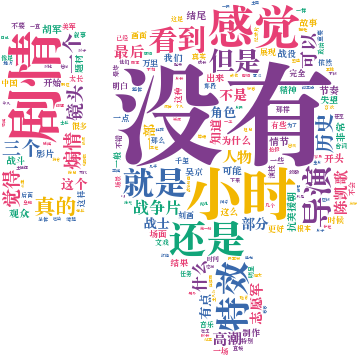

In [14]:
import stylecloud
from IPython.display import Image # 用于在jupyter lab中显示本地图片



# 绘制词云图
stylecloud.gen_stylecloud(text=' '.join(text2),
                            max_words=1000,
                            collocations=False,
                            font_path='/Library/Fonts/Songti.ttc',
                            icon_name='fas fa-thumbs-down',
                            size=360,
                            output_name='豆瓣负向评分词云图.png')

Image(filename='豆瓣负向评分词云图.png')